# Dataset de consumo energético

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import random
random.seed(123)

# Carga del dataset

In [3]:
df = pd.read_csv('extracted_data/csv/hour_merged.csv',
                 parse_dates={'data': ['date', 'time']},
                 infer_datetime_format=True,
                 dayfirst=False,
                 index_col='data'
                )


df.head()

,price,demand,emissions
data,,,
2017-01-01 00:00:00,58.82,24682,14467.2840
2017-01-01 01:00:00,58.23,24046,14173.8295
2017-01-01 02:00:00,51.95,22665,13198.0690
2017-01-01 03:00:00,47.27,21200,12510.7595
2017-01-01 04:00:00,45.49,20056,12203.7315


In [4]:
df.describe()

,price,demand,emissions
count,43800.000000,43800.000000,43800.000000
mean,68.212629,28189.487146,11296.974971
std,63.725022,4595.460802,3952.947375
min,0.010000,16165.000000,3890.149500
25%,40.500000,24380.750000,8181.419000
50%,51.200000,28218.000000,10769.564250
75%,64.100000,31687.000000,13794.362000
max,536.810000,41552.000000,30476.416000


In [5]:
# df = df[int((len(df)*0.6)):]
df = df[int((len(df)*0.8)):]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2021-01-01 00:00:00 to 2021-12-31 23:00:00
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price      8760 non-null   float64
 1   demand     8760 non-null   int64  
 2   emissions  8760 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 273.8 KB


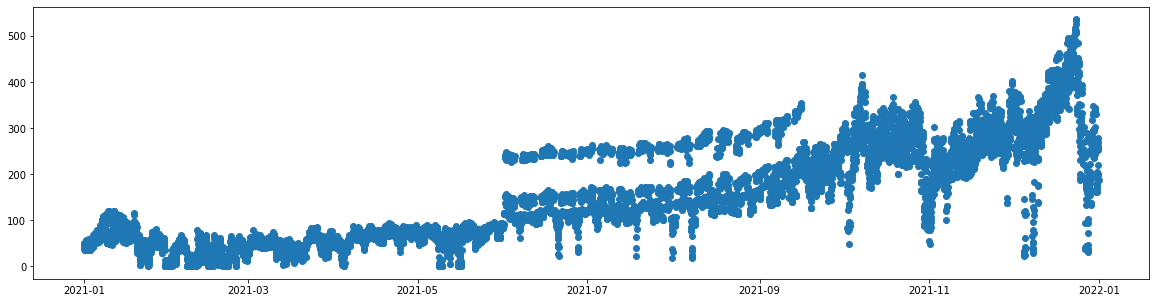

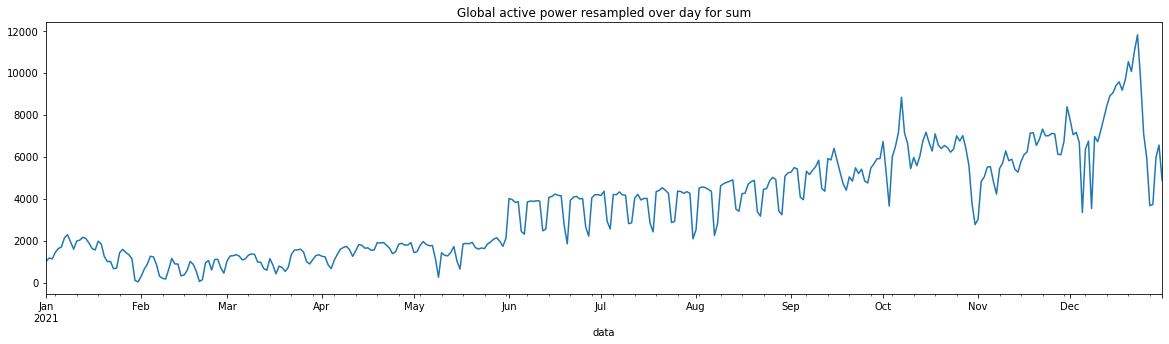

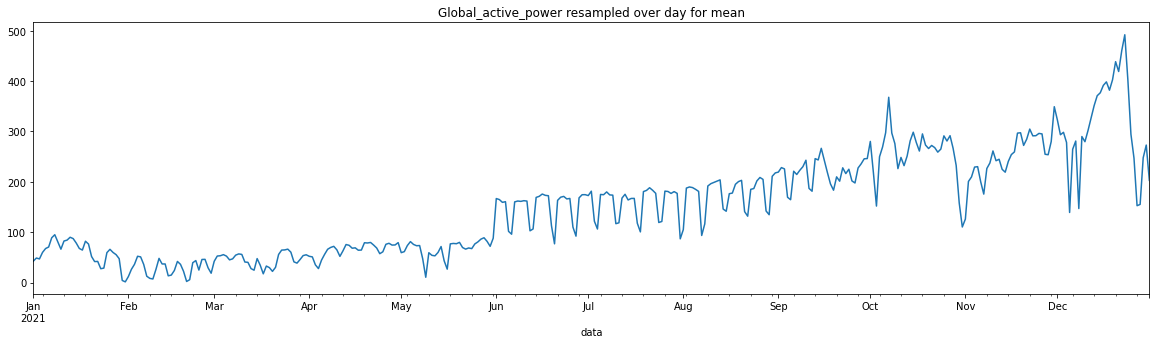

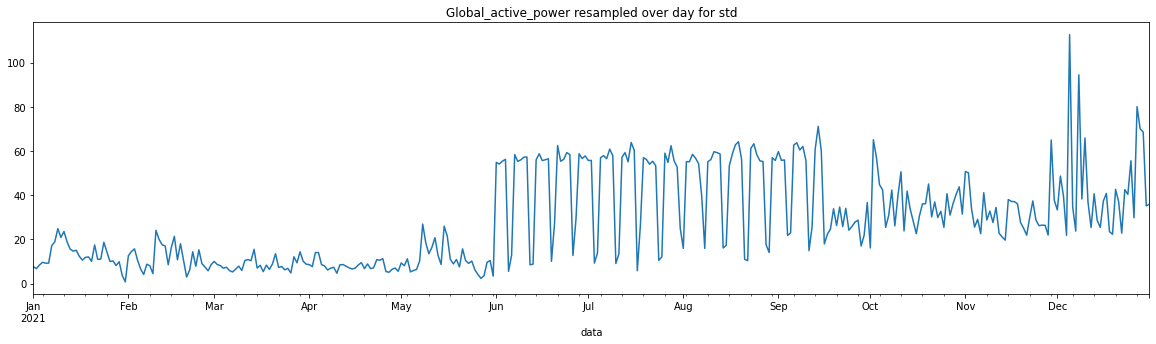

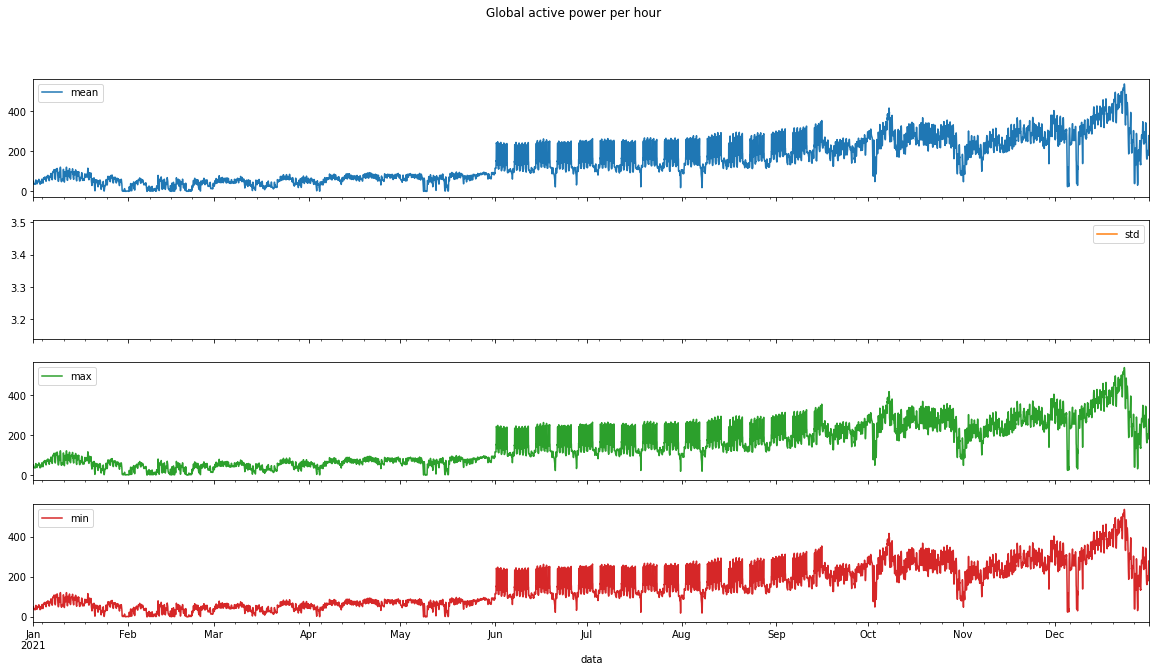

In [7]:
# Scatter plot de Global active power
plt.figure(figsize=(20, 5))
plt.scatter(df.index, df['price'])
plt.show()

# Global active power resampled over day for sum
plt.figure(figsize=(20, 5))
df.price.resample('D').sum().plot(title='Global active power resampled over day for sum')
plt.show()

# # Global active power resampled over day for mean
plt.figure(figsize=(20, 5))
df.price.resample('D').mean().plot(title='Global_active_power resampled over day for mean')
plt.show()

# # Global active power resampled over day for median
plt.figure(figsize=(20, 5))
df.price.resample('D').std().plot(title='Global_active_power resampled over day for std')
plt.show()

# # Global active power per hour
h = df.price.resample('h').agg(['mean', 'std', 'max', 'min'])
h.plot(subplots=True, figsize=(20, 10), title='Global active power per hour')
plt.show()

In [8]:
len(df)

8760

# Differencing

In [9]:
df.head()

,price,demand,emissions
data,,,
2021-01-01 00:00:00,50.87,25134,6356.6480
2021-01-01 01:00:00,48.19,24179,6269.1480
2021-01-01 02:00:00,44.68,22472,5702.4820
2021-01-01 03:00:00,38.50,20319,5284.9275
2021-01-01 04:00:00,36.80,19040,5218.2340


In [10]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [11]:
diff = difference(df['price'])

In [12]:
s1 = pd.Series([0.0])
diff = s1.append(diff, ignore_index=True)
diff

0        0.00
1       -2.68
2       -3.51
3       -6.18
4       -1.70
        ...  
8755    -8.84
8756    -9.14
8757    -8.97
8758   -52.10
8759   -12.24
Length: 8760, dtype: float64

In [13]:
# Formely known as the column price_diff
df['price'] = diff.values

In [14]:
df.tail()

,price,demand,emissions
data,,,
2021-12-31 19:00:00,-8.84,27672,6733.8765
2021-12-31 20:00:00,-9.14,27786,6697.0490
2021-12-31 21:00:00,-8.97,27558,6794.5525
2021-12-31 22:00:00,-52.10,25059,6549.1015
2021-12-31 23:00:00,-12.24,22755,6279.7900


# División en training y test

In [15]:
n = len(df)
# TODO: Modificar (ahora mismo train y test son iguales)
train_df = df[0:int(n*0.8)]
val_df = df[int(n*0.8):]
test_df = df[int(n*0.8):]

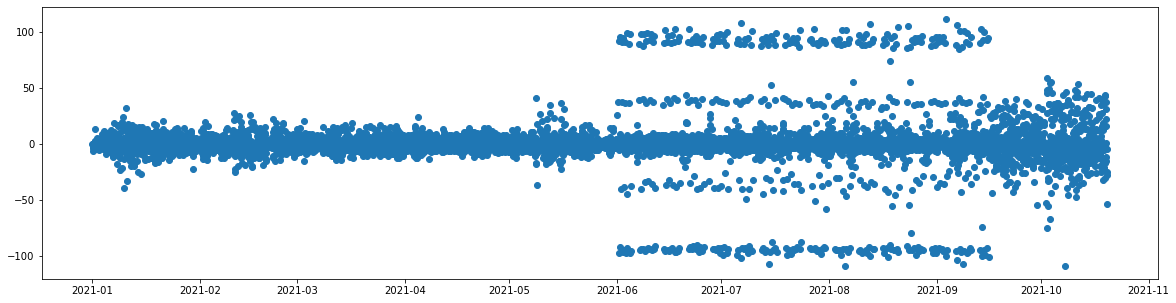

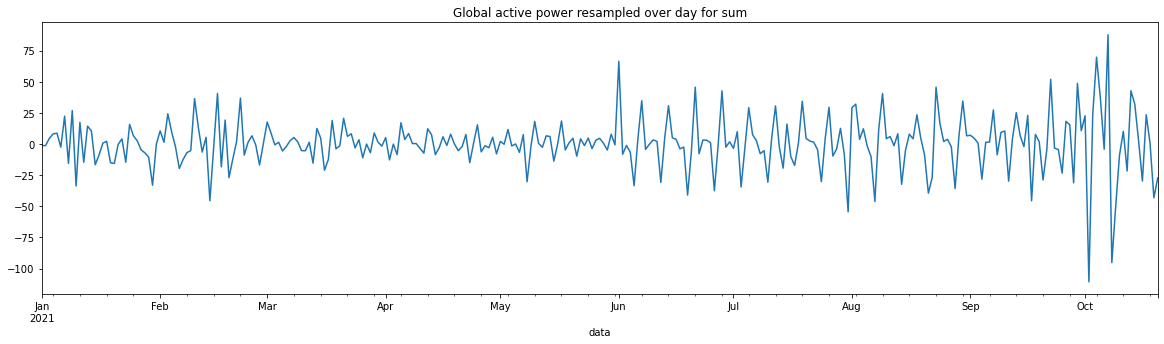

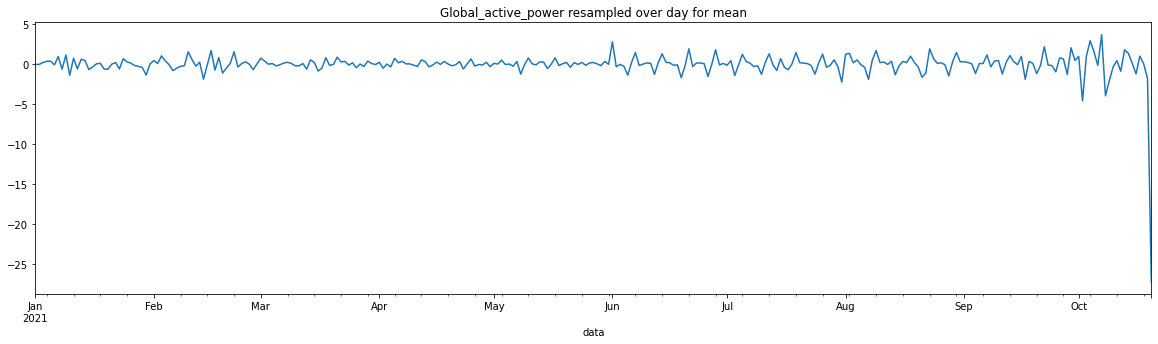

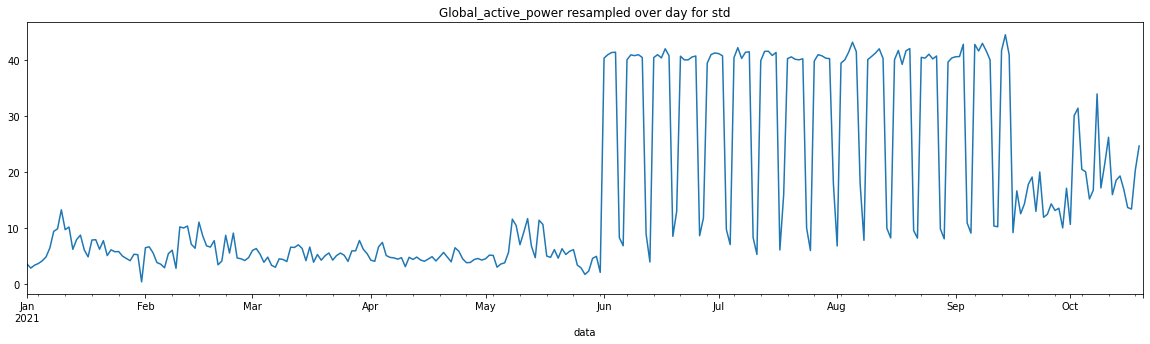

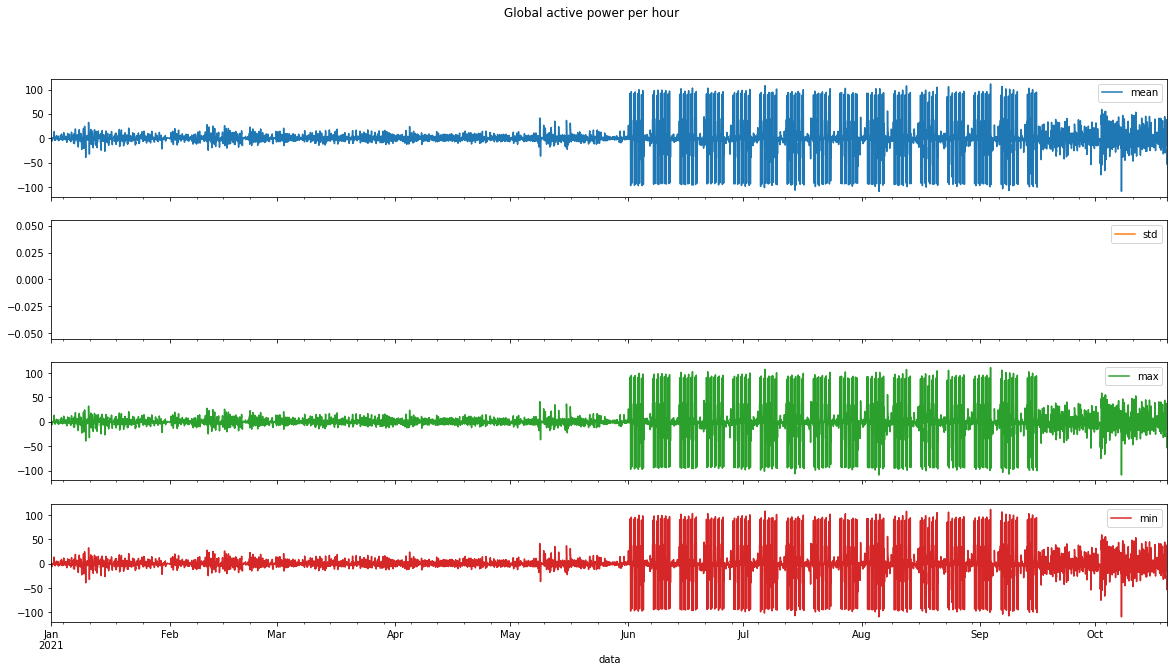

In [16]:
# Scatter plot de Global active power
plt.figure(figsize=(20, 5))
plt.scatter(train_df.index, train_df['price'])
plt.show()

# Global active power resampled over day for sum
plt.figure(figsize=(20, 5))
train_df.price.resample('D').sum().plot(title='Global active power resampled over day for sum')
plt.show()

# # Global active power resampled over day for mean
plt.figure(figsize=(20, 5))
train_df.price.resample('D').mean().plot(title='Global_active_power resampled over day for mean')
plt.show()

# # Global active power resampled over day for median
plt.figure(figsize=(20, 5))
train_df.price.resample('D').std().plot(title='Global_active_power resampled over day for std')
plt.show()

# # Global active power per hour
h = train_df.price.resample('h').agg(['mean', 'std', 'max', 'min'])
h.plot(subplots=True, figsize=(20, 10), title='Global active power per hour')
plt.show()

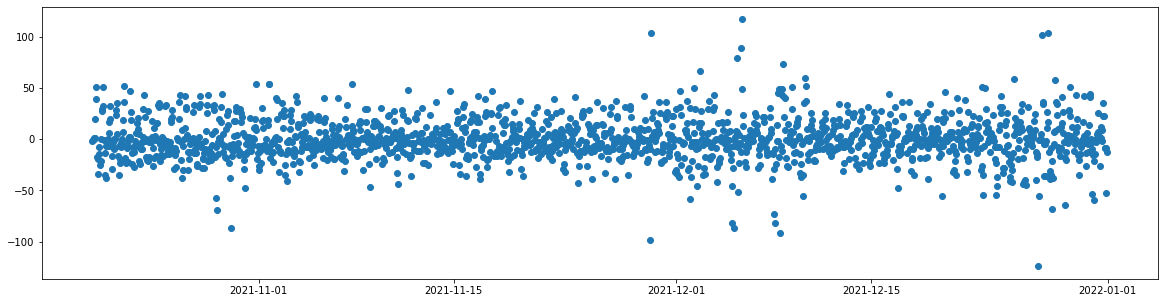

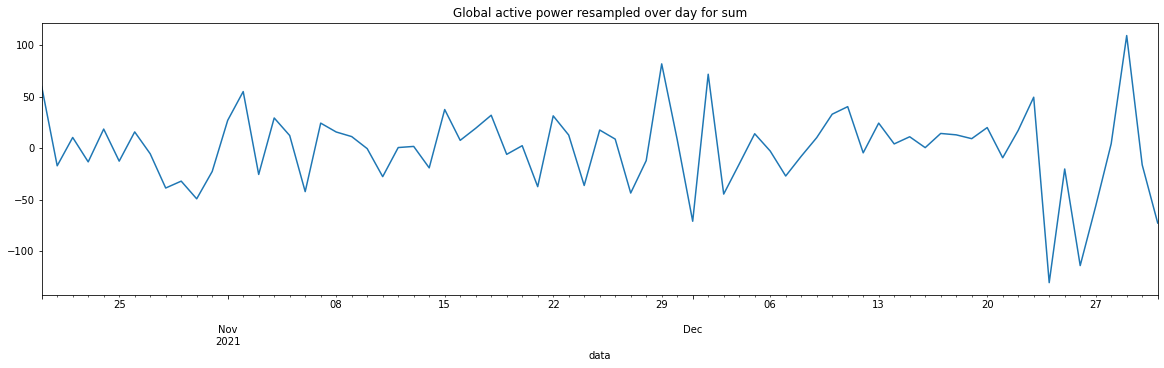

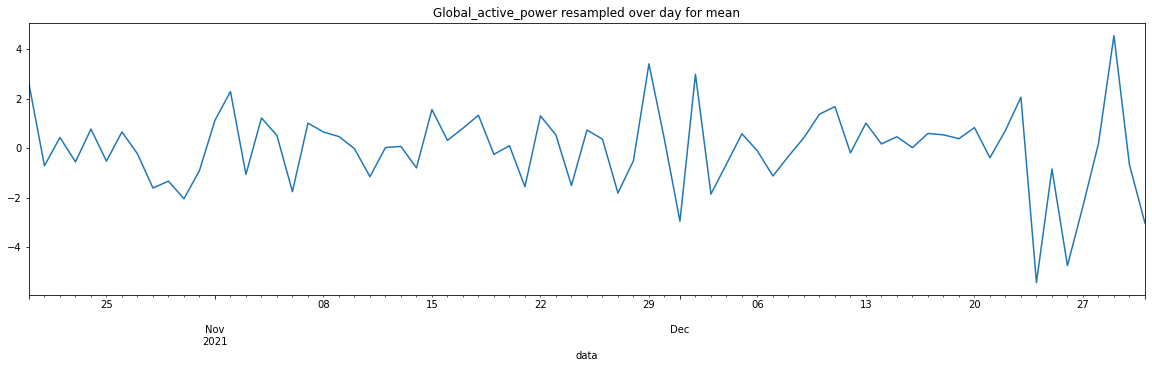

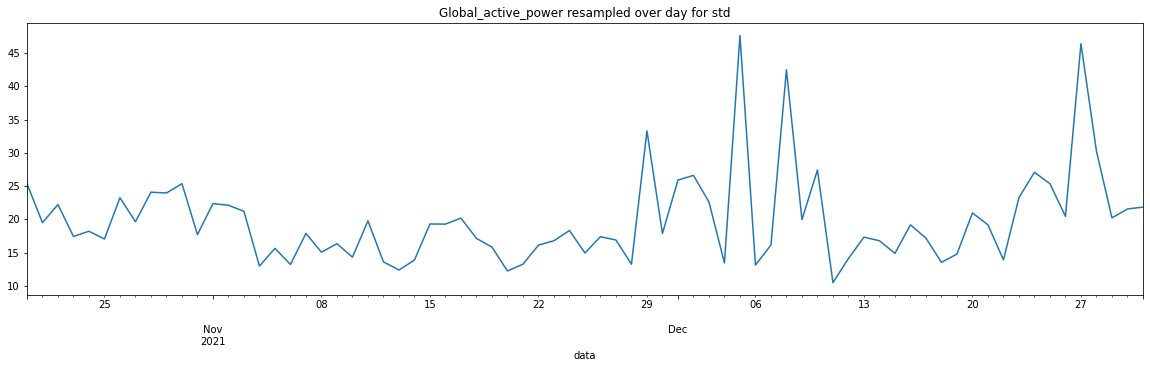

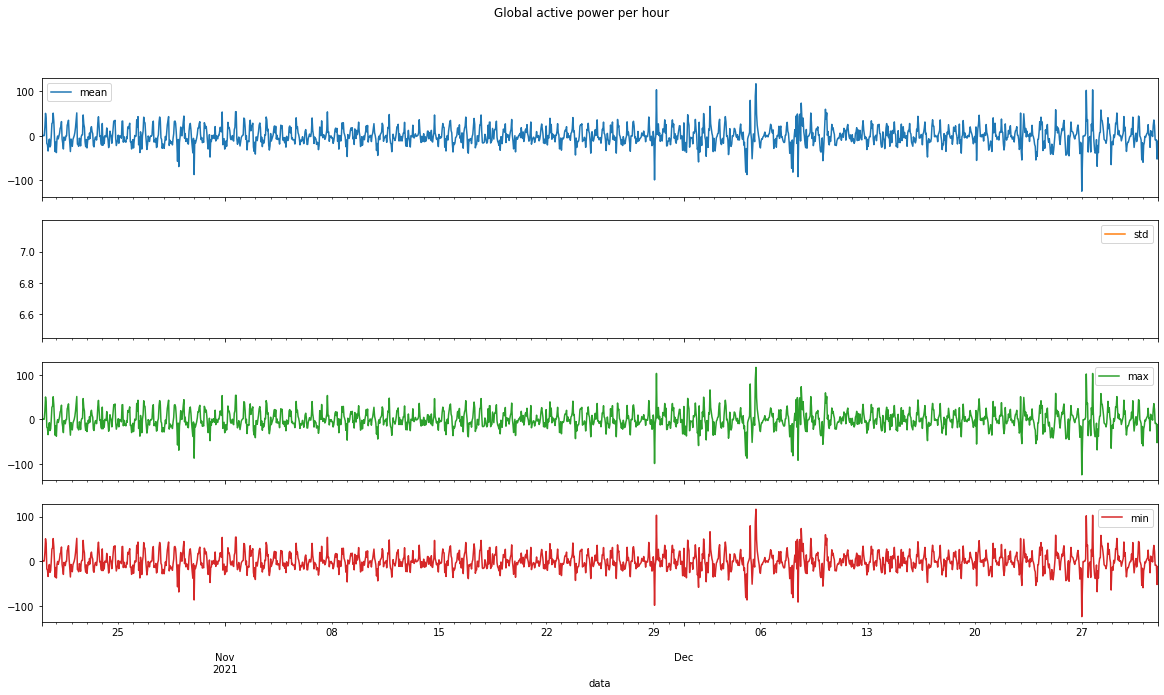

In [17]:
# Scatter plot de Global active power
plt.figure(figsize=(20, 5))
plt.scatter(test_df.index, test_df['price'])
plt.show()

# Global active power resampled over day for sum
plt.figure(figsize=(20, 5))
test_df.price.resample('D').sum().plot(title='Global active power resampled over day for sum')
plt.show()

# # Global active power resampled over day for mean
plt.figure(figsize=(20, 5))
test_df.price.resample('D').mean().plot(title='Global_active_power resampled over day for mean')
plt.show()

# # Global active power resampled over day for median
plt.figure(figsize=(20, 5))
test_df.price.resample('D').std().plot(title='Global_active_power resampled over day for std')
plt.show()

# # Global active power per hour
h = test_df.price.resample('h').agg(['mean', 'std', 'max', 'min'])
h.plot(subplots=True, figsize=(20, 10), title='Global active power per hour')
plt.show()

# Normalización (TODO: Normalizar a un valor más alto)
It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. 

In [18]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [19]:
train_df.head()

,price,demand,emissions
data,,,
2021-01-01 00:00:00,-0.001166,-0.620074,-0.879973
2021-01-01 01:00:00,-0.121941,-0.846596,-0.913820
2021-01-01 02:00:00,-0.159345,-1.251490,-1.133014
2021-01-01 03:00:00,-0.279669,-1.762174,-1.294530
2021-01-01 04:00:00,-0.077777,-2.065548,-1.320328


Distribución de las features

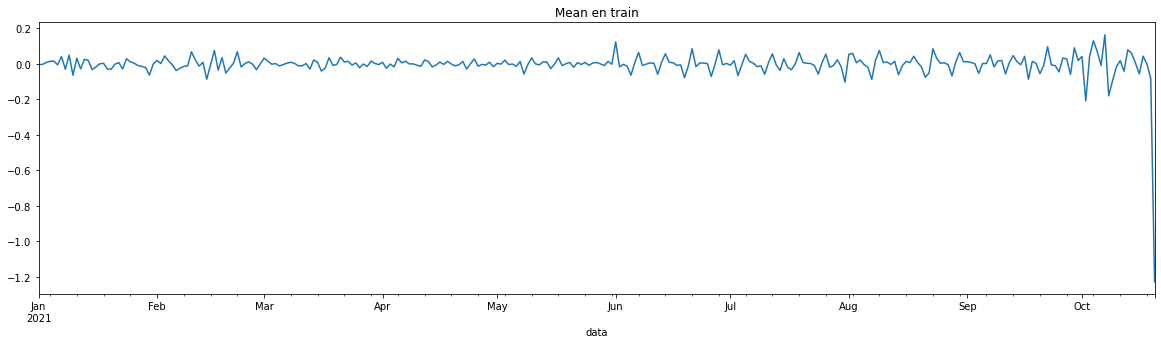

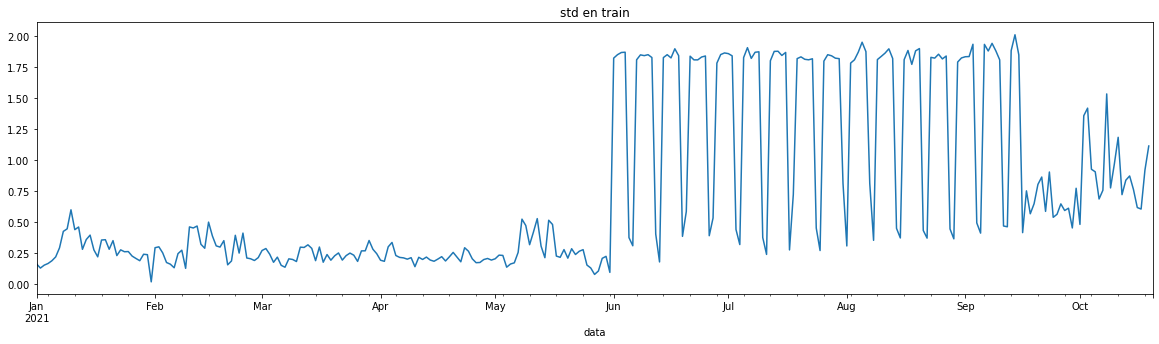

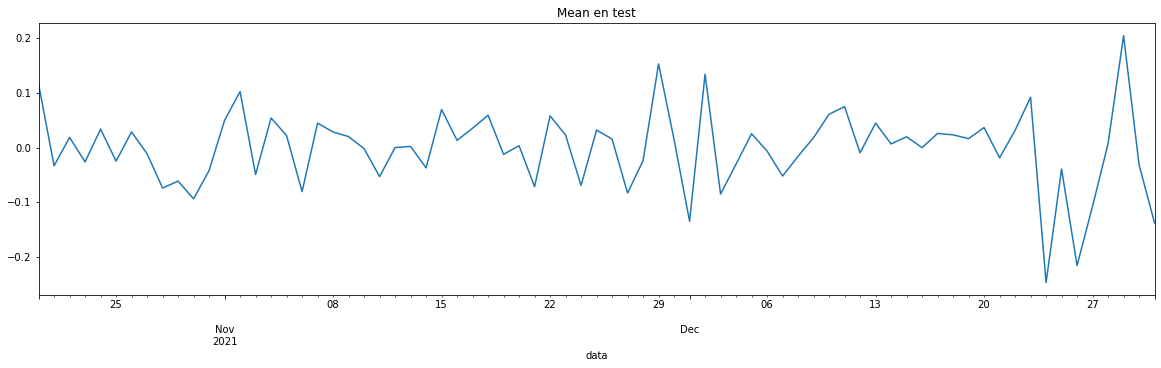

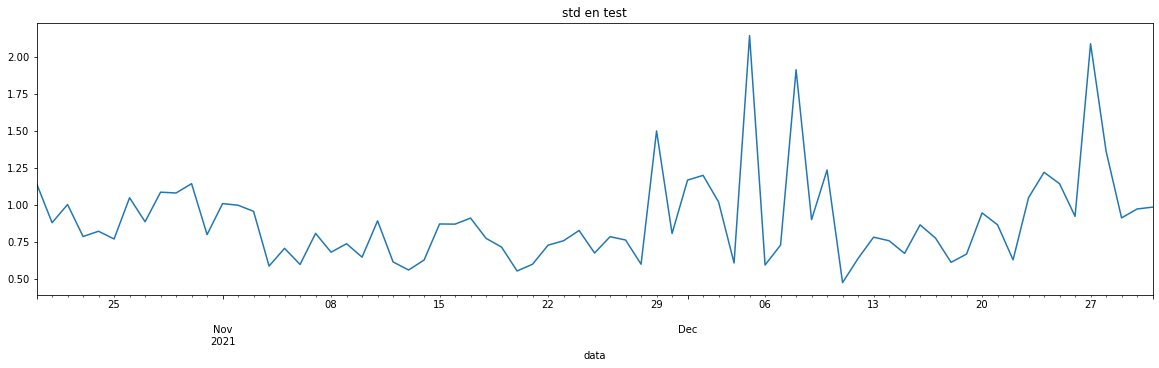

In [20]:
# Mean y std después de la normalización

# # Global active power resampled over day for mean
plt.figure(figsize=(20, 5))
train_df.price.resample('D').mean().plot(title='Mean en train')
plt.show()

# # Global active power resampled over day for median
plt.figure(figsize=(20, 5))
train_df.price.resample('D').std().plot(title='std en train')
plt.show()

# # Global active power resampled over day for mean
plt.figure(figsize=(20, 5))
test_df.price.resample('D').mean().plot(title='Mean en test')
plt.show()

# # Global active power resampled over day for median
plt.figure(figsize=(20, 5))
test_df.price.resample('D').std().plot(title='std en test')
plt.show()

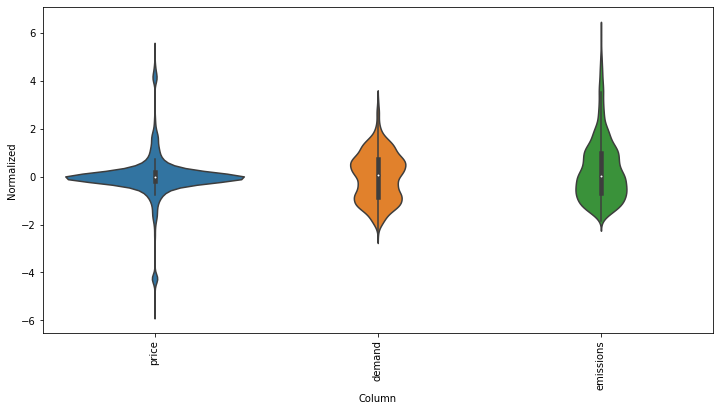

In [21]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# Creación de ventanas

In [22]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [23]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [24]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['price'])
print(w1)

w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['price'])
print(w2)

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['price']
Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['price']


In [25]:
example_window = tf.stack([np.array(test_df[:w2.total_window_size]),
                           np.array(test_df[100:100+w2.total_window_size]),
                           np.array(test_df[200:200+w2.total_window_size])
                          ])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 3)
Inputs shape: (3, 6, 3)
Labels shape: (3, 1, 1)


In [26]:
w2.example = example_inputs, example_labels

In [27]:
def plot(self, model=None, plot_col='price', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

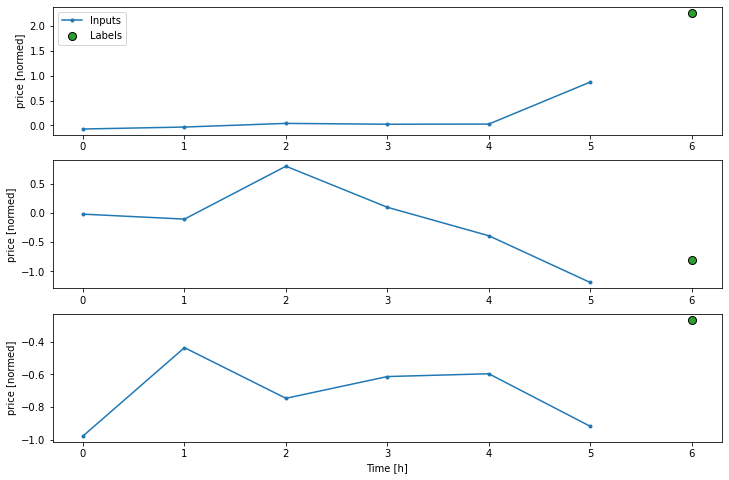

In [28]:
w2.plot()

In [29]:
# De momento, usaremos únicamente la target variable (Household dataset)
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32
    )
    
    ds = ds.map(self.split_window)
    
    return ds

WindowGenerator.make_dataset = make_dataset

In [30]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [31]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [32]:
# Iteramos sobre un conjunto de dataset para producir lotes concretos:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 3)
Labels shape (batch, time, features): (32, 1, 1)


# Multi-step models
Comenzamos intentando predecir una ventana de 24 horas

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

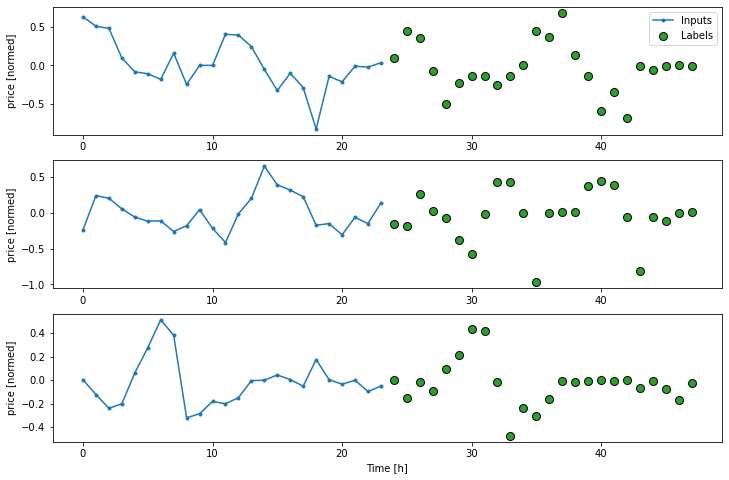

In [33]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS)

multi_window.plot()
multi_window

# Baselines
## Baseline 1: Repetir último input

54/54 [==============================] - 0s 905us/step - loss: 1.6428 - mean_absolute_error: 0.9752 - root_mean_squared_error: 1.2817


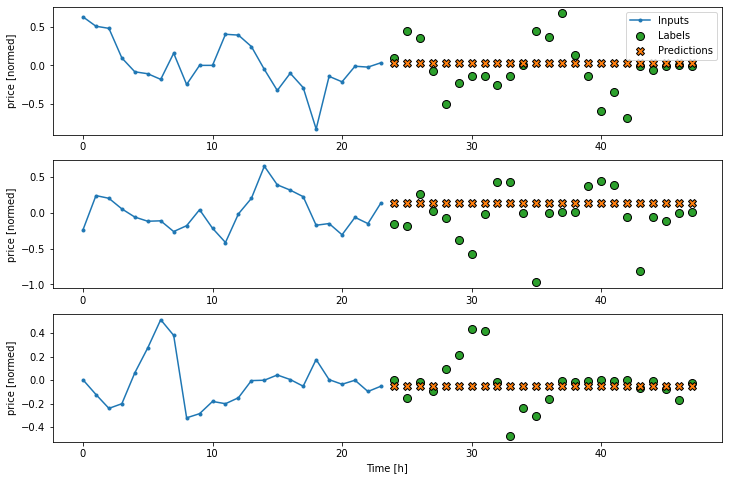

In [34]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(), # TODO: Change
                      metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.RootMeanSquaredError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

## Baseline 2: Repetir la ventana anterior

54/54 [==============================] - 0s 852us/step - loss: 0.8588 - mean_absolute_error: 0.6344 - root_mean_squared_error: 0.9267


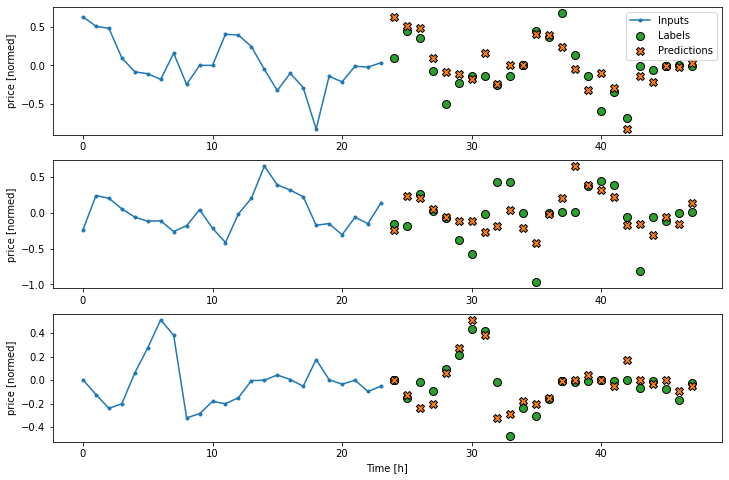

In [35]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.RootMeanSquaredError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

# Single-shot models

## Modelo lineal

In [36]:
num_features=df.shape[1] # TODO: Revisar esta línea

In [37]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                 optimizer=tf.optimizers.Adam(),
                 metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.RootMeanSquaredError()])
    
    history = model.fit(window.train, epochs=MAX_EPOCHS, validation_data = window.val, callbacks=[early_stopping])
    
    return history

Epoch 1/20
218/218 [==============================] - 1s 2ms/step - loss: 0.9188 - mean_absolute_error: 0.6661 - root_mean_squared_error: 0.9585 - val_loss: 1.7436 - val_mean_absolute_error: 0.9689 - val_root_mean_squared_error: 1.3205
Epoch 2/20
218/218 [==============================] - 0s 1ms/step - loss: 0.8157 - mean_absolute_error: 0.6207 - root_mean_squared_error: 0.9032 - val_loss: 1.4350 - val_mean_absolute_error: 0.8911 - val_root_mean_squared_error: 1.1979
Epoch 3/20
218/218 [==============================] - 0s 2ms/step - loss: 0.7606 - mean_absolute_error: 0.5915 - root_mean_squared_error: 0.8721 - val_loss: 1.2541 - val_mean_absolute_error: 0.8431 - val_root_mean_squared_error: 1.1199
Epoch 4/20
218/218 [==============================] - 0s 1ms/step - loss: 0.7298 - mean_absolute_error: 0.5720 - root_mean_squared_error: 0.8543 - val_loss: 1.1486 - val_mean_absolute_error: 0.8133 - val_root_mean_squared_error: 1.0717
Epoch 5/20
218/218 [==============================] - 0s

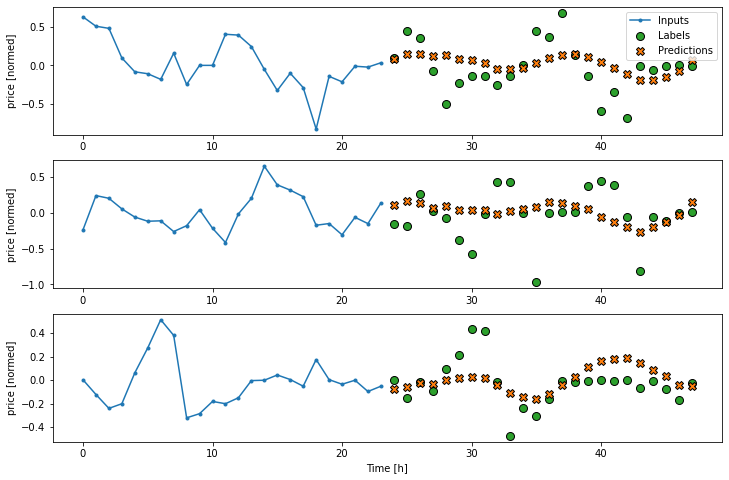

In [38]:
multi_linear_model = tf.keras.Sequential([
    # Seleccionar el último timestep
    # Forma: [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                         kernel_initializer=tf.initializers.zeros()),
    # Shape =>[batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

# IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

## CNN

Epoch 1/20
218/218 [==============================] - 1s 2ms/step - loss: 0.6632 - mean_absolute_error: 0.5443 - root_mean_squared_error: 0.8143 - val_loss: 1.0094 - val_mean_absolute_error: 0.7547 - val_root_mean_squared_error: 1.0047
Epoch 2/20
218/218 [==============================] - 0s 2ms/step - loss: 0.5629 - mean_absolute_error: 0.4983 - root_mean_squared_error: 0.7502 - val_loss: 0.9624 - val_mean_absolute_error: 0.7315 - val_root_mean_squared_error: 0.9810
Epoch 3/20
218/218 [==============================] - 0s 2ms/step - loss: 0.5308 - mean_absolute_error: 0.4828 - root_mean_squared_error: 0.7285 - val_loss: 0.9986 - val_mean_absolute_error: 0.7404 - val_root_mean_squared_error: 0.9993
Epoch 4/20
218/218 [==============================] - 0s 2ms/step - loss: 0.5115 - mean_absolute_error: 0.4738 - root_mean_squared_error: 0.7152 - val_loss: 0.9410 - val_mean_absolute_error: 0.7191 - val_root_mean_squared_error: 0.9700
Epoch 5/20
218/218 [==============================] - 0s

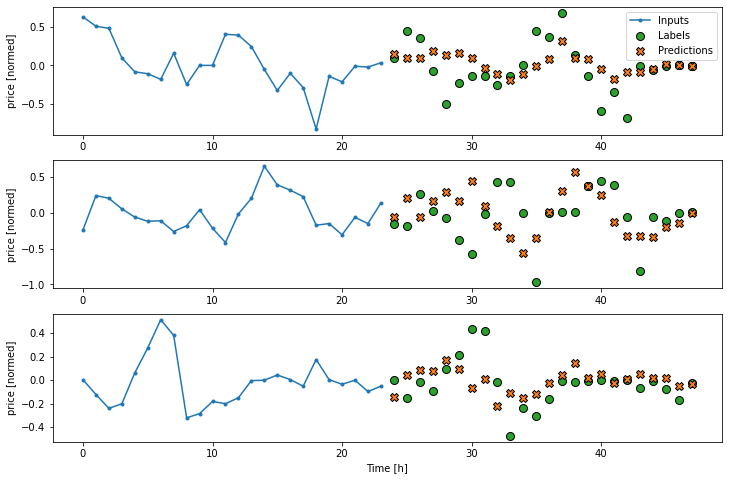

In [39]:
CONV_WIDTH = 3

multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

# IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

## RNN

Epoch 1/20
218/218 [==============================] - 4s 12ms/step - loss: 0.7680 - mean_absolute_error: 0.5820 - root_mean_squared_error: 0.8764 - val_loss: 1.1093 - val_mean_absolute_error: 0.8046 - val_root_mean_squared_error: 1.0532
Epoch 2/20
218/218 [==============================] - 2s 9ms/step - loss: 0.5647 - mean_absolute_error: 0.4695 - root_mean_squared_error: 0.7515 - val_loss: 0.8800 - val_mean_absolute_error: 0.7008 - val_root_mean_squared_error: 0.9381
Epoch 3/20
218/218 [==============================] - 2s 9ms/step - loss: 0.4678 - mean_absolute_error: 0.4183 - root_mean_squared_error: 0.6839 - val_loss: 0.7814 - val_mean_absolute_error: 0.6535 - val_root_mean_squared_error: 0.8839
Epoch 4/20
218/218 [==============================] - 2s 11ms/step - loss: 0.4217 - mean_absolute_error: 0.4015 - root_mean_squared_error: 0.6494 - val_loss: 0.7648 - val_mean_absolute_error: 0.6445 - val_root_mean_squared_error: 0.8745
Epoch 5/20
218/218 [==============================] - 

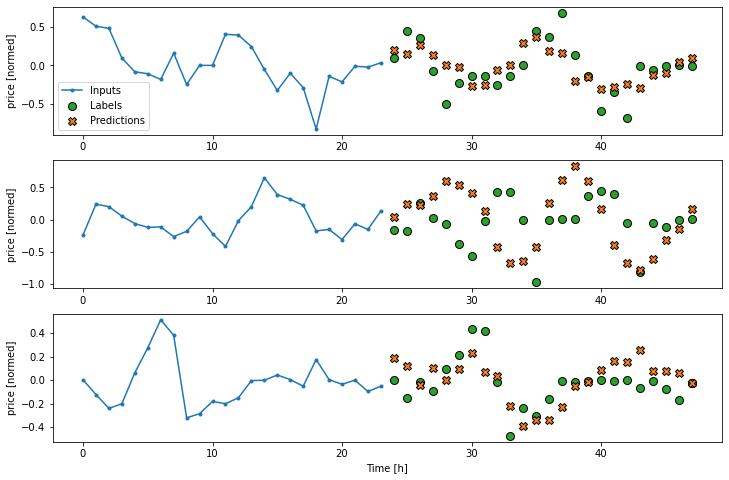

In [40]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Es peligroso añadir demasiadas unidades lstm, ya que pueden causar overfitting
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    # Shape [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

# IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

# Modelo auto-regresivo

In [41]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [42]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [43]:
def warmup(self, inputs):
    # Forma del input => (batch, time, features)
    # Forma de x => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)
    
    # Forma de la predicción => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [44]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 3])

In [45]:
def call(self, inputs, training=None):
    # Usar un TensorArray para capturar unrolled outputs automáticamente
    predictions = []
    # Inicializar el estado de LSTM
    prediction, state = self.warmup(inputs)
    
    # Insertar la primera predicción
    predictions.append(prediction)
    
    # Ejecutar el resto de pasos de la predicción
    for n in range(1, self.out_steps):
        # Usar la última predicción como input
        x = prediction
        # Ejecutar un paso de lstm
        x, state = self.lstm_cell(x, states=state, training=training)
        # Convertir la salida de lstm en una predicción
        prediction = self.dense(x)
        # Añadir la predicción al output
        predictions.append(prediction)
    
    # Forma de predictions => (time, batch, features)
    predictions = tf.stack(predictions)
    # Forma de predictions => (batch, time, features)
    predictions = tf.transpose(predictions, [1,0,2])
    
    return predictions

FeedBack.call = call

In [46]:
print('Forma del output: ', feedback_model(multi_window.example[0]).shape)

Forma del output:  (32, 24, 3)


Epoch 1/20
218/218 [==============================] - 7s 17ms/step - loss: 0.7680 - mean_absolute_error: 0.5810 - root_mean_squared_error: 0.8763 - val_loss: 1.1598 - val_mean_absolute_error: 0.8300 - val_root_mean_squared_error: 1.0769
Epoch 2/20
218/218 [==============================] - 3s 13ms/step - loss: 0.5797 - mean_absolute_error: 0.4747 - root_mean_squared_error: 0.7614 - val_loss: 0.9133 - val_mean_absolute_error: 0.7074 - val_root_mean_squared_error: 0.9557
Epoch 3/20
218/218 [==============================] - 2s 11ms/step - loss: 0.4902 - mean_absolute_error: 0.4145 - root_mean_squared_error: 0.7001 - val_loss: 0.8344 - val_mean_absolute_error: 0.6726 - val_root_mean_squared_error: 0.9135
Epoch 4/20
218/218 [==============================] - 3s 12ms/step - loss: 0.4288 - mean_absolute_error: 0.4029 - root_mean_squared_error: 0.6548 - val_loss: 0.8241 - val_mean_absolute_error: 0.6627 - val_root_mean_squared_error: 0.9078
Epoch 5/20
218/218 [==============================] 

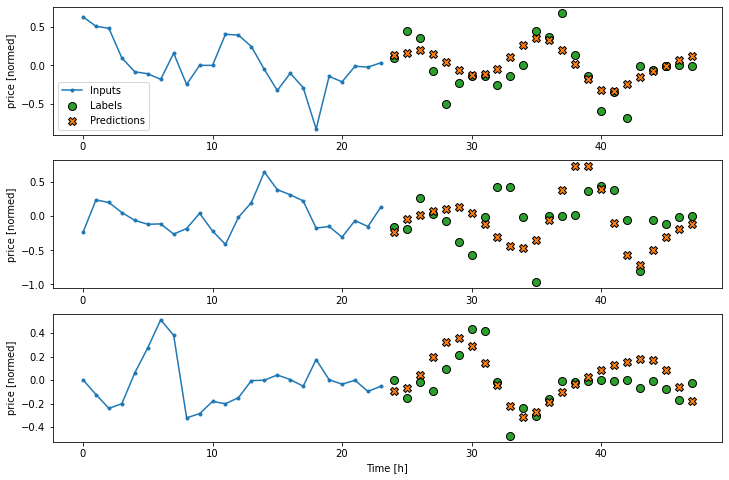

In [47]:
history = compile_and_fit(feedback_model, multi_window)

# IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

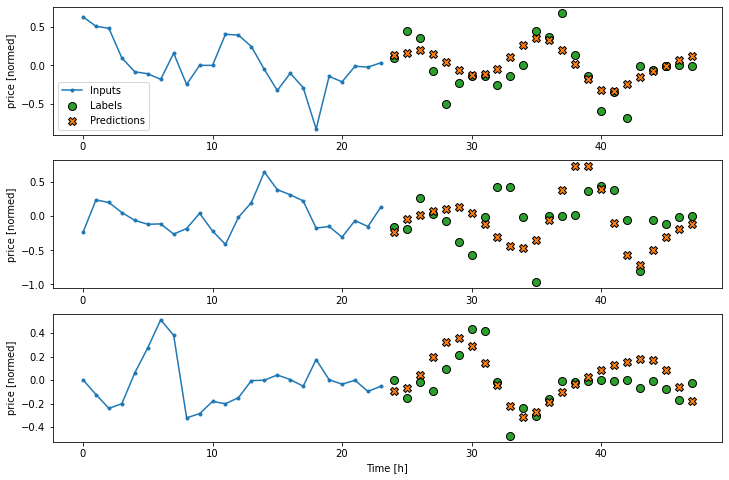

In [48]:
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

In [49]:
train_df.describe()

,price,demand,emissions
count,7.008000e+03,7.008000e+03,7.008000e+03
mean,-1.536696e-17,-4.383543e-17,6.322350e-15
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.922291e+00,-2.247477e+00,-1.834049e+00
25%,-1.597955e-01,-8.151082e-01,-7.833047e-01
50%,-1.919189e-02,4.965004e-02,-1.396657e-01
75%,1.385365e-01,7.198480e-01,7.182824e-01
max,5.017300e+00,3.274214e+00,4.446612e+00


In [50]:
test_df.describe()

,price,demand,emissions
count,1752.000000,1752.000000,1752.000000
mean,-0.002299,0.000201,1.378186
std,0.932857,1.037156,1.736886
min,-5.595565,-2.444350,-1.571979
25%,-0.515022,-0.887453,0.038539
50%,-0.057948,0.050480,1.137769
75%,0.471569,0.835659,2.717532
max,5.261554,2.086098,6.033399
